<a href="https://colab.research.google.com/github/SeemGoel/Multimodal-Phi2/blob/experiments/Copy_of_instruct_150k_preprocess_5thOct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !wget http://images.cocodataset.org/zips/train2014.zip

In [ ]:
# !mv train2014 /content/drive/MyDrive/llm/

In [ ]:
# !apt-get install -y pv

In [ ]:
!7z x '/content/drive/MyDrive/train2014.zip' -o'/content/' -aoa


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 13510573713 bytes (13 GiB)

Extracting archive: /content/drive/MyDrive/train2014.zip
  4% 4096 Open               24% 20480 Open               --
Path = /content/drive/MyDrive/train2014.zip
Type = zip
Physical Size = 13510573713
64-bit = +

  0%      0% 182 - train2014/COCO_train2014_000000340102.jpg                                                      0% 261 - train2014/COCO_train2014_000000039682.jpg  

In [ ]:
# ! wget -q https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import pickle
import os
from tqdm import tqdm
from PIL import Image
import json
import torch
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import pickle
import os
from tqdm import tqdm
from PIL import Image
import json
from concurrent.futures import ThreadPoolExecutor
import numpy as np
# batch_size = 256

In [ ]:
# ! wget https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json

In [ ]:
# '/content/drive/MyDrive/train2014.zip'

### **Code as at 14th Oct 2024**


1. Next Steps for Phi-2 Multimodal Fine-tuning
2. Prepare the Phi-2 Model
3. Load the Phi-2 model
4. Implement QLoRA for efficient fine-tuning
5. Create a Custom Dataset
6. Combine text data from Instruct 150K with CLIP image embeddings
7. Implement a custom PyTorch Dataset class
8. Implement a Projection Layer
9. Create a layer to project CLIP embeddings to Phi-2's hidden dimension
10. Modify Phi-2 for Multimodal Input
11. Adapt the model's forward pass to handle both text and image inputs
12. Set Up the Training Loop
13. Implement a custom training loop or use a library like Hugging Face's Trainer
14. Fine-tune the Model
15. Train the model on the multimodal dataset
16. Monitor and adjust hyperparameters as needed
17. Evaluate the Model
18. Test the fine-tuned model on a held-out validation set
19. Assess performance on multimodal tasks
20. Optimize and Iterate
21. Analyze results and make necessary adjustments
22. Consider techniques like gradient accumulation or mixed-precision training






In [ ]:
import os
import json
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader

# Load the CLIP model and processor on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
class Instruct150KDataset(Dataset):
    def __init__(self, json_file, img_dir):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.image_ids = list(set(entry['image'] for entry in self.data))

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.img_dir, f"COCO_train2014_{image_id}")
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Image not found - {image_path}")
            image = Image.new('RGB', (224, 224))  # Create a blank image as a placeholder
        return image, image_id

def collate_fn(batch):
    images, image_ids = zip(*batch)
    return list(images), list(image_ids)

def generate_embeddings(dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=2, pin_memory=True, collate_fn=collate_fn)

    all_embeddings = []
    all_image_ids = []

    for images, image_ids in tqdm(dataloader, desc="Generating embeddings"):
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            image_features = model.get_image_features(**inputs)

        all_embeddings.append(image_features.cpu().numpy())
        all_image_ids.extend(image_ids)

    return np.concatenate(all_embeddings), all_image_ids

def save_embeddings(embeddings, image_ids, output_file):
    np.savez_compressed(output_file,
                        embeddings=embeddings,
                        image_ids=image_ids)
    print(f"Embeddings saved to {output_file}")

def load_embeddings(file_path):
    data = np.load(file_path)
    return data['embeddings'], data['image_ids']

# Example usage
json_file = '/content/llava_instruct_150k.json'
img_dir = '/content/train2014'
output_file = '/content/drive/MyDrive/LLM/clip_embeddings_instruct150k_15Oct_2024.npz'

# Create dataset
dataset = Instruct150KDataset(json_file, img_dir)

# # Generate and save embeddings
# embeddings, image_ids = generate_embeddings(dataset, batch_size=64)


In [ ]:
# output_file = '/content/drive/MyDrive/llm/clip_embeddings_instruct150k_15Oct_2024.npz'
# save_embeddings(embeddings, image_ids, output_file)

# Load embeddings (for demonstration)
loaded_embeddings, loaded_image_ids = load_embeddings(output_file)

print(f"Embeddings shape: {loaded_embeddings.shape}")
print(f"Number of unique images: {len(loaded_image_ids)}")



In [ ]:
# Example of how to use loaded embeddings
image_id = "000000215677.jpg"  # Note: removed 'COCO_train2014_' prefix
if image_id in loaded_image_ids:
    idx = np.where(loaded_image_ids == image_id)[0][0]
    embedding = loaded_embeddings[idx]
    print(f"Embedding for {image_id}: {embedding[:5]}...")  # Print first 5 values
else:
    print(f"No embedding found for {image_id}")

Embedding for 000000215677.jpg: [-0.05277048  0.5881298  -0.14296937 -0.17500319  0.49110985]...


In [ ]:
!pip install -q transformers peft

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, WhisperProcessor, WhisperModel
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import numpy as np

# Custom dataset class
class MultimodalDataset(Dataset):
    def __init__(self, text_data, image_embeddings, audio_data, tokenizer, whisper_processor, max_length=512):
        self.text_data = text_data
        self.image_embeddings = image_embeddings
        self.audio_data = audio_data
        self.tokenizer = tokenizer
        self.whisper_processor = whisper_processor
        self.max_length = max_length

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        image_embedding = self.image_embeddings[idx]
        audio = self.audio_data[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        processed_audio = self.whisper_processor(audio, return_tensors="pt").input_features

        return {
            'input_ids': encoded_text['input_ids'].squeeze(),
            'attention_mask': encoded_text['attention_mask'].squeeze(),
            'image_embedding': torch.tensor(image_embedding, dtype=torch.float32),
            'audio_features': processed_audio.squeeze()
        }

# Projection layers for image and audio embeddings
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Main model class
class MultimodalModel(nn.Module):
    def __init__(self, base_model, image_projection, audio_projection):
        super().__init__()
        self.base_model = base_model
        self.image_projection = image_projection
        self.audio_projection = audio_projection

    def forward(self, input_ids, attention_mask, image_embedding, audio_features):
        projected_image = self.image_projection(image_embedding)
        projected_audio = self.audio_projection(audio_features)

        # Combine text, image, and audio inputs
        combined_input = torch.cat([projected_image.unsqueeze(1), projected_audio.unsqueeze(1), input_ids], dim=1)
        combined_attention_mask = torch.cat([torch.ones_like(projected_image.unsqueeze(1)),
                                             torch.ones_like(projected_audio.unsqueeze(1)),
                                             attention_mask], dim=1)

        outputs = self.base_model(input_ids=combined_input, attention_mask=combined_attention_mask)
        return outputs

# Function to load and prepare the model
def load_and_prepare_model(model_name, image_embedding_dim, audio_embedding_dim, model_embedding_dim):
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # Prepare base model with QLoRA
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True,
    )

    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
    )
    base_model = prepare_model_for_kbit_training(base_model)

    # Add LoRA adapter
    lora_config = LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["query_key_value"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    base_model = get_peft_model(base_model, lora_config)

    # Create projection layers
    image_projection = ProjectionLayer(image_embedding_dim, model_embedding_dim)
    audio_projection = ProjectionLayer(audio_embedding_dim, model_embedding_dim)

    # Combine base model and projection layers
    model = MultimodalModel(base_model, image_projection, audio_projection)

    return model, tokenizer

# Training function
def train(model, train_dataloader, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_embedding = batch['image_embedding'].to(device)
            audio_features = batch['audio_features'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, image_embedding, audio_features)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader)}")

# Main execution
def main():
    # Load your data (replace with your actual data loading logic)
    text_data = ["Your text data here"]  # Load your text data
    image_embeddings = np.random.rand(len(text_data), 512)  # Replace with your actual CLIP embeddings
    audio_data = [np.random.rand(16000) for _ in range(len(text_data))]  # Replace with your actual audio data

    # Model parameters
    model_name = "microsoft/phi-2"  # Replace with your chosen Phi model
    image_embedding_dim = 512  # CLIP embedding dimension
    audio_embedding_dim = 512  # Whisper embedding dimension
    model_embedding_dim = 768  # Phi model embedding dimension (adjust if needed)

    # Load Whisper model and processor
    whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
    whisper_model = WhisperModel.from_pretrained("openai/whisper-base")

    # Load and prepare the model
    model, tokenizer = load_and_prepare_model(model_name, image_embedding_dim, audio_embedding_dim, model_embedding_dim)

    # Create dataset and dataloader
    dataset = MultimodalDataset(text_data, image_embeddings, audio_data, tokenizer, whisper_processor)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Training setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    # Train the model
    num_epochs = 3  # Adjust as needed
    train(model, dataloader, optimizer, num_epochs, device)

    # Save the trained model
    model.save_pretrained("path/to/save/model")
    tokenizer.save_pretrained("path/to/save/tokenizer")

if __name__ == "__main__":
    main()

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model_name = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_name,pad_token="[PAD]")

# Print model architecture
print(model)

# Identify potential target modules
target_modules = [name for name, module in model.named_modules() if isinstance(module, torch.nn.Linear)]
print("Potential target modules:", target_modules)

# Choose appropriate target modules (example)
chosen_targets = ["mlp.dense_4h_to_h", "mlp.dense_h_to_4h", "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj"]

model = prepare_model_for_kbit_training(model)
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=chosen_targets,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, config)

print("LoRA model created successfully!")

In [ ]:
import torch.nn as nn
class ProjectionLayer(nn.Module):
    def __init__(self, clip_dim, phi2_dim):
        super().__init__()
        self.projection = nn.Linear(clip_dim, phi2_dim)

    def forward(self, x):
        return self.projection(x)

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
# import clip
from transformers import WhisperProcessor, WhisperModel

In [ ]:
whisper_processor = WhisperProcessor.from_pretrained("openai/whisper-base")
whisper_model = WhisperModel.from_pretrained("openai/whisper-base")
whisper_projection = torch.nn.Linear(whisper_model.config.d_model, model.config.hidden_size).to(device)

In [ ]:
import torch
from torch.utils.data import Dataset
import json
import numpy as np
from transformers import AutoTokenizer


Version 2 of data iteration by claudi

In [ ]:
import torch
from torch.utils.data import IterableDataset
import json
import numpy as np
from transformers import AutoTokenizer
from collections import Counter
from tqdm import tqdm


class MultimodalDataset(IterableDataset):
    def __init__(self, json_file, embedding_file, tokenizer_name, max_length=512):
        self.tokenizer = AutoTokenizer.from_pretrained(
            tokenizer_name, pad_token="[PAD]"
        )
        self.max_length = max_length
        self.json_file = json_file
        self.embedding_file = embedding_file

        # Load CLIP embeddings
        embeddings_data = np.load(embedding_file)
        print(f"Keys in the embedding file: {embeddings_data.files}")

        # Try to load embeddings with different possible key names
        embedding_key = next(
            (key for key in embeddings_data.files if "embedding" in key.lower()), None
        )
        if embedding_key:
            self.image_embeddings = embeddings_data[embedding_key]
        else:
            raise KeyError("No embedding key found in the NPZ file")

        # Try to load ids with different possible key names
        id_key = next(
            (key for key in embeddings_data.files if "id" in key.lower()), None
        )
        if id_key:
            self.image_ids = embeddings_data[id_key]
        else:
            raise KeyError("No id key found in the NPZ file")

        print(f"Loaded embeddings shape: {self.image_embeddings.shape}")
        print(f"Loaded ids shape: {self.image_ids.shape}")

        # Create a mapping from image_id to embedding index
        self.image_id_to_index = {id: idx for idx, id in enumerate(self.image_ids)}

        self.missing_embeddings = Counter()

        # Load the JSON data to get the total number of items
        with open(self.json_file, 'r') as f:
            self.data = json.load(f)

        # Calculate the total number of conversation pairs
        self.total_items = sum(len(item['conversations']) // 2 for item in self.data)

        print(f"Total number of conversation pairs: {self.total_items}")

    def __iter__(self):
        with open(self.json_file, "r") as f:
            data = json.load(f)
            for item in data:
                try:
                    image_id = (
                        item["image"].replace(".jpg", "").replace("COCO_train2014_", "")
                    )
                    for i in range(0, len(item["conversations"]), 2):
                        human_conv = item["conversations"][i]
                        gpt_conv = (
                            item["conversations"][i + 1]
                            if i + 1 < len(item["conversations"])
                            else None
                        )

                        if (
                            human_conv["from"] == "human"
                            and gpt_conv
                            and gpt_conv["from"] == "gpt"
                        ):
                            question = (
                                human_conv["value"].replace("<image>\n", "").strip()
                            )
                            answer = gpt_conv["value"]

                            # Tokenize input
                            input_text = f"Human: {question}\nAssistant: {answer}"
                            tokenized = self.tokenizer(
                                input_text,
                                truncation=True,
                                max_length=self.max_length,
                                padding="max_length",
                            )

                            # Get image embedding
                            image_embedding = self.get_image_embedding(image_id)

                            yield {
                                "input_ids": torch.tensor(tokenized["input_ids"]),
                                "attention_mask": torch.tensor(
                                    tokenized["attention_mask"]
                                ),
                                "labels": torch.tensor(tokenized["input_ids"]),
                                "image_embeddings": torch.tensor(
                                    image_embedding
                                ).float(),
                            }

                except Exception as e:
                    print(f"Error processing item: {str(e)}")
                    print(f"Problematic item: {item}")

    def get_image_embedding(self, image_id):
        if image_id in self.image_id_to_index:
            return self.image_embeddings[self.image_id_to_index[image_id]]
        else:
            self.missing_embeddings[image_id] += 1
            return np.zeros(self.image_embeddings.shape[1])

    def print_missing_embeddings_summary(self):
        print("\nMissing Embeddings Summary:")
        print(f"Total unique missing embeddings: {len(self.missing_embeddings)}")
        print(
            f"Total missing embedding occurrences: {sum(self.missing_embeddings.values())}"
        )
        print("\nTop 10 missing embeddings:")
        for image_id, count in self.missing_embeddings.most_common(10):
            print(f"Image ID: {image_id}, Count: {count}")

    def save_to_json(self, output_file, limit=None):
        print(f"Saving dataset to JSON: {output_file}")
        dataset = []
        for item in tqdm(self.data[:limit] if limit else self.data, desc="Processing items"):
            try:
                image_id = item['image'].replace('.jpg', '').replace('COCO_train2014_', '')
                image_embedding = self.get_image_embedding(image_id).tolist()

                for i in range(0, len(item['conversations']), 2):
                    human_conv = item['conversations'][i]
                    gpt_conv = item['conversations'][i+1] if i+1 < len(item['conversations']) else None

                    if human_conv['from'] == 'human' and gpt_conv and gpt_conv['from'] == 'gpt':
                        question = human_conv['value'].replace("<image>\n", "").strip()
                        answer = gpt_conv['value']

                        dataset_item = {
                            "image_id": image_id,
                            "question": question,
                            "answer": answer,
                            "image_embedding": image_embedding
                        }
                        dataset.append(dataset_item)

            except Exception as e:
                print(f"Error processing item: {str(e)}")
                print(f"Problematic item: {item}")

        with open(output_file, 'w') as f:
            json.dump(dataset, f, indent=2)

        print(f"Dataset saved to {output_file}")
        print(f"Total items saved: {len(dataset)}")


import torch
from torch.utils.data import DataLoader

# Main execution
if __name__ == "__main__":
    json_file = '/content/llava_instruct_150k.json'
    tokenizer_name = 'microsoft/phi-2'
    embedding_file = '/content/drive/MyDrive/LLM/clip_embeddings_instruct150k_15Oct_2024.npz'

    print(f"Initializing dataset with:")
    print(f"JSON file: {json_file}")
    print(f"Embedding file: {embedding_file}")
    print(f"Tokenizer: {tokenizer_name}")

    dataset = MultimodalDataset(json_file, embedding_file, tokenizer_name)

    # Create a DataLoader
    batch_size = 64
    print(f"Creating DataLoader with batch size: {batch_size}")
    dataloader = DataLoader(dataset, batch_size=batch_size)

    # Calculate the number of batches
    num_batches = (dataset.total_items + batch_size - 1) // batch_size
    print(f"Total number of batches: {num_batches}")

    # Iterate through the data
    print("Starting data iteration...")
    try:
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches", total=num_batches)):
            # Unpack the batch
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]
            image_embeddings = batch["image_embeddings"]

            # Here you would typically process your batch, e.g., pass it through your model
            # For demonstration, we'll just print the shapes of each tensor
            print(f"\nBatch {batch_idx + 1}")
            print(f"Input IDs shape: {input_ids.shape}")
            print(f"Attention mask shape: {attention_mask.shape}")
            print(f"Labels shape: {labels.shape}")
            print(f"Image embeddings shape: {image_embeddings.shape}")

            # Break after first batch for demonstration purposes
            # Remove this line to process all batches
            # if batch_idx == 0:
            #     break

        print("Data iteration complete!")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    # Print missing embeddings summary
    print("\nPrinting missing embeddings summary:")
    dataset.print_missing_embeddings_summary()

    # Save dataset to JSON
    json_output_file = '/content/drive/MyDrive/processed_dataset.json'
    print("\nSaving dataset to JSON...")
    dataset.save_to_json(json_output_file, limit=1000)  # Set limit=None to process all items


In [ ]:
dataset_list = [item for item in dataset]  # Convert the iterable dataset to a list
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset_list, test_size=0.2, random_state=42)  # 80% train, 20% test

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

NameError: name 'train_dataset' is not defined

In [ ]:
# prompt: write both train and test in seprate json files

# ... (Your existing code) ...

# Save train and test datasets to separate JSON files
train_json_output_file = '/content/drive/MyDrive/train_dataset.json'
test_json_output_file = '/content/drive/MyDrive/test_dataset.json'

print("\nSaving train dataset to JSON...")
with open(train_json_output_file, 'w') as f:
    # Convert tensors to lists before serializing
    json.dump([
        {k: v.tolist() if isinstance(v, torch.Tensor) else v for k, v in item.items()}
        for item in train_dataset
    ], f, indent=2)

print("\nSaving test dataset to JSON...")
with open(test_json_output_file, 'w') as f:
    # Convert tensors to lists before serializing
    json.dump([
        {k: v.tolist() if isinstance(v, torch.Tensor) else v for k, v in item.items()}
        for item in test_dataset
    ], f, indent=2)

print(f"Train dataset saved to {train_json_output_file}")
print(f"Test dataset saved to {test_json_output_file}")


Saving train dataset to JSON...


In [ ]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration

class AudioProcessor:
    def __init__(self, model_name="openai/whisper-base"):
        self.processor = WhisperProcessor.from_pretrained(model_name)
        self.model = WhisperForConditionalGeneration.from_pretrained(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def transcribe(self, audio_file):
        # Load and preprocess the audio file
        audio_input = self.processor(audio_file, return_tensors="pt").input_features.to(self.device)

        # Generate the transcription
        with torch.no_grad():
            generated_ids = self.model.generate(audio_input)

        # Decode the generated ids to text
        transcription = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return transcription

    def get_audio_embeddings(self, audio_file):
        # Load and preprocess the audio file
        audio_input = self.processor(audio_file, return_tensors="pt").input_features.to(self.device)

        # Get the audio embeddings
        with torch.no_grad():
            outputs = self.model(audio_input, output_hidden_states=True)

        # Use the last hidden state as the audio embedding
        audio_embeddings = outputs.last_hidden_state.mean(dim=1)
        return audio_embeddings.cpu().numpy()

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import get_peft_model, LoraConfig, TaskType

class MultimodalPhi2(nn.Module):
    def __init__(self, phi2_model_name, clip_embedding_dim, whisper_embedding_dim, phi2_hidden_dim):
        super().__init__()
        self.phi2 = AutoModelForCausalLM.from_pretrained(phi2_model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(phi2_model_name)

        # Projection layers
        self.clip_projection = nn.Linear(clip_embedding_dim, phi2_hidden_dim)
        self.whisper_projection = nn.Linear(whisper_embedding_dim, phi2_hidden_dim)

        # Apply LoRA
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1
        )
        self.phi2 = get_peft_model(self.phi2, peft_config)

    def forward(self, input_ids, attention_mask, image_embeddings=None, audio_embeddings=None):
        # Project image embeddings if present
        if image_embeddings is not None:
            image_proj = self.clip_projection(image_embeddings)
            # Concatenate image projections with input embeddings
            input_embeds = self.phi2.model.embed_tokens(input_ids)
            input_embeds[:, 0, :] += image_proj  # Add to first token

        # Project audio embeddings if present
        if audio_embeddings is not None:
            audio_proj = self.whisper_projection(audio_embeddings)
            # Concatenate audio projections with input embeddings
            if image_embeddings is None:
                input_embeds = self.phi2.model.embed_tokens(input_ids)
            input_embeds[:, 1, :] += audio_proj  # Add to second token

        # Forward pass through Phi-2
        outputs = self.phi2(inputs_embeds=input_embeds, attention_mask=attention_mask)
        return outputs


In [ ]:
data

NpzFile '/content/drive/MyDrive/llm/clip_embeddings_instruct150k_15Oct_2024.npz' with keys: embeddings, image_ids

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the existing embeddings file
embedding_file = '/content/drive/MyDrive/llm/clip_embeddings_instruct150k_15Oct_2024.npz'
data = np.load(embedding_file)

# Extract the data
image_ids = data['image_ids']
embeddings = data['embeddings']

# Split the data (80% train, 20% validation)
train_ids, val_ids,train_embeddings, val_embeddings = train_test_split(
    image_ids, embeddings, test_size=0.2, random_state=42
)

# Save the training data
np.savez('/content/drive/MyDrive/llm/clip_embeddings_train.npz',
         image_ids=train_ids,
         embeddings=train_embeddings)

# Save the validation data
np.savez('/content/drive/MyDrive/llm/clip_embeddings_val.npz',
         image_ids=val_ids,
         embeddings=val_embeddings)

print("Data split and saved successfully.")
print(f"Training samples: {len(train_ids)}")
print(f"Validation samples: {len(val_ids)}")

Data split and saved successfully.
Training samples: 65183
Validation samples: 16296


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
# from model import MultimodalPhi2
# from data_loader import MultimodalDataset

def train(model, train_dataloader, val_dataloader, num_epochs, device):
    optimizer = AdamW(model.parameters(), lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0

        for batch in tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            image_embeddings = batch['image_embeddings'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, image_embeddings=image_embeddings)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Average training loss: {avg_loss}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                image_embeddings = batch['image_embeddings'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, image_embeddings=image_embeddings)
                loss = outputs.loss
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_dataloader)
        print(f"Validation loss: {avg_val_loss}")
        model.train()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load your dataset
    train_dataset = MultimodalDataset("train_data.json", "train_embeddings.npz", "microsoft/phi-2")
    val_dataset = MultimodalDataset("val_data.json", "val_embeddings.npz", "microsoft/phi-2")

    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8)

    model = MultimodalPhi2("microsoft/phi-2", clip_embedding_dim=512, whisper_embedding_dim=768, phi2_hidden_dim=2560)

    train(model, train_dataloader, val_dataloader, num_epochs=3, device=device)

NameError: name 'MultimodalDataset' is not defined

In [ ]:
# import torch
# from torch.utils.data import IterableDataset
# import json
# import numpy as np
# from transformers import AutoTokenizer

# class MultimodalDataset(IterableDataset):
#     def __init__(self, json_file, embedding_file, tokenizer_name, max_length=512):
#         self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, pad_token="[PAD]")
#         self.max_length = max_length
#         self.json_file = json_file
#         self.embedding_file = embedding_file

#         # Load CLIP embeddings
#         embeddings_data = np.load(embedding_file)
#         print(f"Keys in the embedding file: {embeddings_data.files}")

#         # Try to load embeddings with different possible key names
#         embedding_key = next((key for key in embeddings_data.files if 'embedding' in key.lower()), None)
#         if embedding_key:
#             self.image_embeddings = embeddings_data[embedding_key]
#         else:
#             raise KeyError("No embedding key found in the NPZ file")

#         # Try to load ids with different possible key names
#         id_key = next((key for key in embeddings_data.files if 'id' in key.lower()), None)
#         if id_key:
#             self.image_ids = embeddings_data[id_key]
#         else:
#             raise KeyError("No id key found in the NPZ file")

#         print(f"Loaded embeddings shape: {self.image_embeddings.shape}")
#         print(f"Loaded ids shape: {self.image_ids.shape}")

#         # Create a mapping from image_id to embedding index
#         self.image_id_to_index = {id: idx for idx, id in enumerate(self.image_ids)}

#     def __iter__(self):
#         with open(self.json_file, 'r') as f:
#             data = json.load(f)
#             for item in data:
#                 try:
#                     image_id = item['image'] #.replace('.jpg', '').replace('COCO_train2014_', '')
#                     for i in range(0, len(item['conversations']), 2):
#                         human_conv = item['conversations'][i]
#                         gpt_conv = item['conversations'][i+1] if i+1 < len(item['conversations']) else None

#                         if human_conv['from'] == 'human' and gpt_conv and gpt_conv['from'] == 'gpt':
#                             question = human_conv['value'].replace("<image>\n", "").strip()
#                             answer = gpt_conv['value']

#                             # Tokenize input
#                             input_text = f"Human: {question}\nAssistant: {answer}"
#                             tokenized = self.tokenizer(input_text, truncation=True, max_length=self.max_length, padding='max_length')

#                             # Get image embedding
#                             image_embedding = self.get_image_embedding(image_id)

#                             yield {
#                                 "input_ids": torch.tensor(tokenized['input_ids']),
#                                 "attention_mask": torch.tensor(tokenized['attention_mask']),
#                                 "labels": torch.tensor(tokenized['input_ids']),
#                                 "image_embeddings": torch.tensor(image_embedding).float()
#                             }

#                 except Exception as e:
#                     print(f"Error processing item: {str(e)}")
#                     print(f"Problematic item: {item}")

#     def get_image_embedding(self, image_id):
#         if image_id in self.image_id_to_index:
#             return self.image_embeddings[self.image_id_to_index[image_id]]
#         else:
#             print(f"Warning: No embedding found for image {image_id}")
#             return np.zeros(self.image_embeddings.shape[1])

# # The rest of your code remains the same

In [ ]:
# #  The rest of your code (DataLoader and testing loop) remains the same

# import torch
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# # Assuming you've already defined and instantiated the updated MultimodalDataset
# json_file = '/content/llava_instruct_150k.json'
# tokenizer_name = 'microsoft/phi-2'
# embedding_file = '/content/drive/MyDrive/llm/clip_embeddings_instruct150k_15Oct_2024.npz'

# print(f"Initializing dataset with:")
# print(f"JSON file: {json_file}")
# print(f"Embedding file: {embedding_file}")
# print(f"Tokenizer: {tokenizer_name}")

# dataset = MultimodalDataset(json_file, embedding_file, tokenizer_name)

# # Create a DataLoader
# batch_size = 32
# print(f"Creating DataLoader with batch size: {batch_size}")
# dataloader = DataLoader(dataset, batch_size=batch_size)

# # Iterate through the data
# print("Starting data iteration...")
# try:
#     for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
#         # Unpack the batch
#         input_ids = batch['input_ids']
#         attention_mask = batch['attention_mask']
#         labels = batch['labels']
#         image_embeddings = batch['image_embeddings']

#         # Here you would typically process your batch, e.g., pass it through your model
#         # For demonstration, we'll just print the shapes of each tensor
#         print(f"\nBatch {batch_idx + 1}")
#         print(f"Input IDs shape: {input_ids.shape}")
#         print(f"Attention mask shape: {attention_mask.shape}")
#         print(f"Labels shape: {labels.shape}")
#         print(f"Image embeddings shape: {image_embeddings.shape}")

#         # Break after first batch for demonstration purposes
#         # Remove this line to process all batches
#         # if batch_idx == 0:
#         #     break

#     print("Data iteration complete!")
# except Exception as e:
#     print(f"An error occurred: {str(e)}")

# # # Print missing embeddings summary
# # print("\nPrinting missing embeddings summary:")
# # dataset.print_missing_embeddings_summary()

In [ ]:
# dataset = MultimodalDataset(json_file, embedding_file, tokenizer_name,batch_size=8)
# print(f"Dataset size: {len(dataset)}")

# # Example of accessing an item
# sample_item = dataset[0]
# print("Sample item keys:", sample_item.keys())
# print("Input IDs shape:", sample_item['input_ids'].shape)
# print("Image embedding shape:", sample_item['image_embeddings'].shape)

In [ ]:
import json
with open('multimodal_dataset.json', 'w') as f:
     json.dump(dataset.processed_data, f, indent=4)  # indent for readability

AttributeError: 'MultimodalDataset' object has no attribute 'processed_data'

In [ ]:
training_args = TrainingArguments(
    output_dir="./phi2_multimodal",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    save_steps=100,
    logging_steps=10,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=100,
    do_eval=True
)

In [ ]:
# prompt: class MultimodalTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         # Implement custom loss computation
#         # Combine text, image, and audio inputs
#         pass

from transformers import Trainer

class MultimodalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Implement custom loss computation
        # Combine text, image, and audio inputs
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(outputs.logits.view(-1, outputs.logits.size(-1)), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = MultimodalTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

trainer.train()


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import json
import os
import numpy as np
from tqdm import tqdm
import pickle
import multiprocessing
from functools import partial

class OptimizedCLIPEmbeddingGenerator:
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def generate_embeddings(self, texts, images):
        try:
            inputs = self.processor(text=texts, images=images, return_tensors="pt", padding=True).to(self.device)

            with torch.no_grad():
                outputs = self.model(**inputs)
                text_embeddings = outputs.text_embeds.cpu().numpy()
                image_embeddings = outputs.image_embeds.cpu().numpy()

            return text_embeddings, image_embeddings
        except Exception as e:
            print(f"Error generating embeddings: {e}")
            return None, None

def load_image(path):
    try:
        return Image.open(path)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

def load_images(image_paths):
    with multiprocessing.Pool() as pool:
        return pool.map(load_image, image_paths)

def process_llava_instruct_dataset(llava_json_path, image_folder_path, output_file, batch_size=32, checkpoint_interval=1000):
    # Load the LLaVA dataset
    try:
        with open(llava_json_path, "r") as file:
            llava_data = json.load(file)
    except Exception as e:
        print(f"Error loading dataset from {llava_json_path}: {e}")
        return

    clip_generator = OptimizedCLIPEmbeddingGenerator()

    # Use memory-mapped arrays for large datasets
    ids = np.memmap(f"{output_file}_ids.dat", dtype='U100', mode='w+', shape=(len(llava_data),))
    prompts = np.memmap(f"{output_file}_prompts.dat", dtype='U1000', mode='w+', shape=(len(llava_data),))
    image_filenames = np.memmap(f"{output_file}_image_filenames.dat", dtype='U100', mode='w+', shape=(len(llava_data),))
    prompt_embeddings = np.memmap(f"{output_file}_prompt_embeddings.dat", dtype='float32', mode='w+', shape=(len(llava_data), 512))
    image_embeddings = np.memmap(f"{output_file}_image_embeddings.dat", dtype='float32', mode='w+', shape=(len(llava_data), 512))

    # Load processed data checkpoint if it exists
    start_index = 0
    if os.path.exists(f"{output_file}_checkpoint.pkl"):
        try:
            with open(f"{output_file}_checkpoint.pkl", 'rb') as f:
                start_index = pickle.load(f)
            print(f"Resuming from checkpoint at index {start_index}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")

    for i in tqdm(range(start_index, len(llava_data), batch_size), desc="Processing dataset"):
        batch_entries = llava_data[i:i+batch_size]

        batch_prompts = []
        batch_image_paths = []
        batch_ids = []

        for entry in batch_entries:
            image_filename = entry['image']
            image_path = os.path.join(image_folder_path, f"COCO_train2014_{image_filename}")
            for conversation in entry['conversations']:
                if conversation['from'] == 'human':
                    prompt = conversation['value'].strip()
                    batch_prompts.append(prompt)
                    batch_image_paths.append(image_path)
                    batch_ids.append(entry['id'])

        batch_images = load_images(batch_image_paths)

        # Generate embeddings for valid images
        valid_indices = [index for index, img in enumerate(batch_images) if img is not None]
        valid_prompts = [batch_prompts[idx] for idx in valid_indices]
        valid_images = [batch_images[idx] for idx in valid_indices]
        valid_ids = [batch_ids[idx] for idx in valid_indices]

        if valid_prompts and valid_images:
            batch_prompt_embeddings, batch_image_embeddings = clip_generator.generate_embeddings(valid_prompts, valid_images)

            if batch_prompt_embeddings is not None and batch_image_embeddings is not None:
                end_index = i + len(valid_ids)
                ids[i:end_index] = valid_ids
                prompts[i:end_index] = valid_prompts
                image_filenames[i:end_index] = [os.path.basename(batch_image_paths[idx]) for idx in valid_indices]
                prompt_embeddings[i:end_index] = batch_prompt_embeddings
                image_embeddings[i:end_index] = batch_image_embeddings

        # Save checkpoint every checkpoint_interval steps
        if (i + len(batch_entries)) % checkpoint_interval == 0:
            try:
                with open(f"{output_file}_checkpoint.pkl", 'wb') as f:
                    pickle.dump(i + len(batch_entries), f)
                print(f"Checkpoint saved at {i + len(batch_entries)} entries.")
            except Exception as e:
                print(f"Error saving checkpoint: {e}")

    # Final save after all processing
    try:
        np.savez(output_file,
                 ids=ids[:end_index],
                 prompts=prompts[:end_index],
                 image_filenames=image_filenames[:end_index],
                 prompt_embeddings=prompt_embeddings[:end_index],
                 image_embeddings=image_embeddings[:end_index])
        print(f"Processed data saved to {output_file}")
    except Exception as e:
        print(f"Error saving processed data to {output_file}: {e}")

    # Clean up memory-mapped files
    del ids, prompts, image_filenames, prompt_embeddings, image_embeddings
    os.remove(f"{output_file}_ids.dat")
    os.remove(f"{output_file}_prompts.dat")
    os.remove(f"{output_file}_image_filenames.dat")
    os.remove(f"{output_file}_prompt_embeddings.dat")
    os.remove(f"{output_file}_image_embeddings.dat")

# Utility function to load processed data for training with error handling for ValueError
def load_processed_data(file_path):
    try:
        data = np.load(file_path)
        return {
            'ids': data['ids'],
            'prompts': data['prompts'],
            'image_filenames': data['image_filenames'],
            'prompt_embeddings': data['prompt_embeddings'],
            'image_embeddings': data['image_embeddings']
        }
    except Exception as e:
        print(f"Error loading processed data from {file_path}: {e}")
        return None

# Main execution
if __name__ == "__main__":
    print("Processing LLaVA Instruct dataset...")
    process_llava_instruct_dataset('llava_instruct_150k.json', '/content/train2014', '/content/drive/MyDrive/processed_llava_instruct_data_14thOct_2024.npz')


Processing LLaVA Instruct dataset...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Processing dataset:   3%|▎         | 125/4929 [07:28<4:26:48,  3.33s/it]

Checkpoint saved at 4000 entries.


Processing dataset:   5%|▌         | 250/4929 [15:04<4:51:41,  3.74s/it]

Checkpoint saved at 8000 entries.


Processing dataset:   8%|▊         | 375/4929 [22:40<4:53:18,  3.86s/it]

Checkpoint saved at 12000 entries.


Processing dataset:   9%|▉         | 442/4929 [26:45<4:31:34,  3.63s/it]


KeyboardInterrupt: 

In [ ]:
# import zipfile
# import os
# from tqdm import tqdm

# # Path to zipfile
# zipfile_path = '/content/drive/MyDrive/train2014.zip'

# # Destination directory on Colab disk
# destination_path = '/content/'

# # Create the destination directory if it doesn't exist
# os.makedirs(destination_path, exist_ok=True)

# try:
#     with zipfile.ZipFile(zipfile_path, 'r') as zip_ref:
#         all_files = zip_ref.namelist()

#         # Filter files to only include those in 'train2014/'
#         target_files = [f for f in all_files if f.startswith('train2014/')]

#         # Use tqdm to show progress
#         for idx, file in enumerate(tqdm(target_files, desc='Extracting')):
#             zip_ref.extract(file, destination_path)

#             # Print a message every 10,000 files processed
#             if (idx + 1) % 10000 == 0:
#                 print(f"Processed {idx + 1} files.")

# except FileNotFoundError:
#     print(f"Error: The file {zipfile_path} was not found.")
# except zipfile.BadZipFile:
#     print(f"Error: The file {zipfile_path} is not a valid zip file.")
# except Exception as e:
#     print(f"An unexpected error occurred: {e}")

In [ ]:
load_processed_data("/content/drive/MyDrive/processed_llava_instruct_data.npz")

{'ids': array(['000000033471', '000000033471', '000000033471', ...,
        '000000111936', '000000129216', '000000542485'], dtype='<U12'),
 'prompts': array(['<image>\nWhat are the colors of the bus in the image?',
        'What feature can be seen on the back of the bus?',
        'Is the bus driving down the street or pulled off to the side?',
        ...,
        '<image>\nWhat considerations must the train conductor and passengers take into account while boarding the train in this situation?',
        '<image>\nWhat advice could the man in the image give to someone just starting their career?',
        '<image>\nWhat might be the purpose of the items displayed on the table?'],
       dtype='<U274'),
 'image_filenames': array(['COCO_train2014_000000033471.jpg',
        'COCO_train2014_000000033471.jpg',
        'COCO_train2014_000000033471.jpg', ...,
        'COCO_train2014_000000111936.jpg',
        'COCO_train2014_000000129216.jpg',
        'COCO_train2014_000000542485.jpg'], dty

In [ ]:
import numpy as np
import torch

# Step 1: Load the .npz file
file_path = "/content/drive/MyDrive/processed_llava_instruct_data.npz" # Replace with your actual file path
loaded_data = np.load(file_path)

# Step 2: Check keys in the loaded .npz file (for verification)
print("Keys in the .npz file:", loaded_data.keys())

# Assuming your embeddings are stored under the key 'image_embeddings' and are in shape (303539, 512)
image_embeddings = loaded_data['image_embeddings']

# Step 3: Convert the numpy array to a torch tensor
image_embeddings_tensor = torch.tensor(image_embeddings, dtype=torch.float32)

# Example: If you want to use a batch of embeddings (let's say first 32 images)
batch_size = 32
image_batch = image_embeddings_tensor[:batch_size]

# Step 4: Now you can proceed with further steps like adding a projection layer or passing it into a model
print("Batch shape:", image_batch.shape)  # Should be (32, 512)


Keys in the .npz file: KeysView(NpzFile '/content/drive/MyDrive/processed_llava_instruct_data.npz' with keys: ids, prompts, image_filenames, prompt_embeddings, image_embeddings)
Batch shape: torch.Size([32, 512])


In [ ]:
import torch.nn as nn

# Step 5: Define a projection layer (from 512 -> 768)
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim=512, output_dim=768):
        super(ProjectionLayer, self).__init__()
        self.projection = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.projection(x)

# Step 6: Instantiate the projection layer
projection_layer = ProjectionLayer(input_dim=512, output_dim=768)

# Step 7: Apply the projection layer to your image batch
projected_image_embeddings = projection_layer(image_batch)
print("Projected Image Embeddings Shape:", projected_image_embeddings.shape)  # Should be (32, 768)



Projected Image Embeddings Shape: torch.Size([32, 768])


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Step 8: Create a DataLoader for the image embeddings tensor
batch_size = 32
dataset = TensorDataset(image_embeddings_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Step 9: Process all embeddings through the projection layer in batches
projected_embeddings_list = []
for batch in tqdm(dataloader, desc="Projecting embeddings"):
    image_batch = batch[0]  # Get the image batch
    projected_batch = projection_layer(image_batch)  # Project the embeddings
    projected_embeddings_list.append(projected_batch)

# Step 10: Concatenate the projected embeddings to form the full tensor
projected_image_embeddings = torch.cat(projected_embeddings_list, dim=0)
print("Full Projected Image Embeddings Shape:", projected_image_embeddings.shape)


Projecting embeddings: 100%|██████████| 9486/9486 [00:16<00:00, 564.56it/s]


Full Projected Image Embeddings Shape: torch.Size([303539, 768])


In [ ]:
# Save the projected embeddings to a file (on disk)
torch.save(projected_image_embeddings, "projected_image_embeddings.pt")


In [ ]:
# Inspect a few projected embeddings (e.g., first 5)
print(projected_image_embeddings[:5])


tensor([[ 0.0239, -0.0335, -0.0333,  ..., -0.0173, -0.0261, -0.0329],
        [ 0.0239, -0.0335, -0.0333,  ..., -0.0173, -0.0261, -0.0329],
        [ 0.0239, -0.0335, -0.0333,  ..., -0.0173, -0.0261, -0.0329],
        [ 0.0703, -0.0441, -0.0483,  ...,  0.0037, -0.0202, -0.0459],
        [ 0.0703, -0.0441, -0.0483,  ...,  0.0037, -0.0202, -0.0459]],
       grad_fn=<SliceBackward0>)


In [ ]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
#Load image and text embeddings
image_embeddings = loaded_data['image_embeddings']  # Assuming this key holds your image embeddings
text_embeddings = loaded_data['prompt_embeddings']    # Assuming this key holds your text embeddings

# Convert to PyTorch tensors
image_embeddings_tensor = torch.tensor(image_embeddings, dtype=torch.float32)
text_embeddings_tensor = torch.tensor(text_embeddings, dtype=torch.float32)

print("Image Embeddings Shape:", image_embeddings_tensor.shape)
print("Text Embeddings Shape:", text_embeddings_tensor.shape)

Image Embeddings Shape: torch.Size([303539, 512])
Text Embeddings Shape: torch.Size([303539, 512])


In [ ]:
# Check if projection is necessary
if image_embeddings_tensor.shape[1] != 768:
    projection_layer = torch.nn.Linear(512, 768)  # Assuming image embeddings are (303539, 512)
    projected_image_embeddings = projection_layer(image_embeddings_tensor)
else:
    projected_image_embeddings = image_embeddings_tensor

print("Projected Image Embeddings Shape:", projected_image_embeddings.shape)

Projected Image Embeddings Shape: torch.Size([303539, 768])


In [ ]:
# Combine embeddings
combined_embeddings = torch.cat((projected_image_embeddings, text_embeddings_tensor), dim=1)  # Concatenate along the last dimension
print("Combined Embeddings Shape:", combined_embeddings.shape)  # Should be (N, 768 + 768) = (N, 1536) for each pair

Combined Embeddings Shape: torch.Size([303539, 1280])


In [ ]:
from transformers import AutoModel, AutoTokenizer

# Load the Phi-2 model and tokenizer
model_name = "microsoft/Phi-2"  # Adjust this according to the actual model name
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Assuming combined_embeddings is already prepared
# combined_embeddings shape: (303539, 1280)
# You can create a DataLoader if needed for batch processing
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset
dataset = TensorDataset(combined_embeddings)

# Create a DataLoader
batch_size = 32  # Adjust according to your requirements
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch.optim as optim

# Set model to training mode
model.train()

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)  # Adjust learning rate as needed

# Training Loop
for epoch in range(num_epochs):  # Set your number of epochs
    for batch in dataloader:
        # Get the embeddings
        inputs = batch[0]  # TensorDataset returns a tuple; we just want the embeddings

        # Forward pass
        outputs = model(inputs)  # You may need to adjust this depending on model requirements

        # Calculate loss here (if you have labels)
        loss = ...  # Define your loss calculation

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} completed.")


In [ ]:
import zipfile
import os

npz_file_path  = "/content/drive/MyDrive/processed_llava_instruct_data.npz"
# Create zip archive
try:
    with zipfile.ZipFile('/content/drive/MyDrive/image_text_embeddings.zip', 'w') as zipf:
        zipf.write(npz_file_path, os.path.basename(npz_file_path))
    print(f"Successfully created zip archive: {'/content/drive/MyDrive/image_text_embeddings.zip'}")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully created zip archive: /content/drive/MyDrive/image_text_embeddings.zip


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CombinedDataset(Dataset):
    def __init__(self, image_embeddings, text_embeddings):
        self.image_embeddings = image_embeddings
        self.text_embeddings = text_embeddings

    def __len__(self):
        return len(self.image_embeddings)

    def __getitem__(self, idx):
        return self.image_embeddings[idx], self.text_embeddings[idx]

# Create a dataset
combined_dataset = CombinedDataset(projected_image_embeddings, text_embeddings)

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

# Sample data retrieval
for img_embeds, txt_embeds in dataloader:
    print("Image Embeddings Shape:", img_embeds.shape)  # Should be (batch_size, 768)
    print("Text Embeddings Shape:", txt_embeds.shape)
    break  # Just print one batch


IndexError: index 31072 is out of bounds for dimension 0 with size 32

In [ ]:
# Define a placeholder for audio input (using Whisper)
class AudioProjectionLayer(nn.Module):
    def __init__(self, input_dim=512, output_dim=768):
        super(AudioProjectionLayer, self).__init__()
        self.projection = nn.Linear(input_dim, output_dim)

    def forward(self, audio_embeddings):
        return self.projection(audio_embeddings)

# Placeholder for audio embeddings (will be Whisper transcriptions later)
audio_embeddings = torch.randn(32, 512)

# Define projection layer for audio embeddings
audio_projection_layer = AudioProjectionLayer(input_dim=512, output_dim=768)

# Project audio embeddings
projected_audio_embeddings = audio_projection_layer(audio_embeddings)
print("Projected Audio Embeddings Shape:", projected_audio_embeddings.shape)


NameError: name 'nn' is not defined

In [ ]:
# import torch
# from transformers import CLIPProcessor, CLIPModel
# import os
# import json
# import numpy as np
# from tqdm import tqdm
# from PIL import Image

# batch_size = 256

# class CLIPEmbeddingGenerator:
#     def __init__(self, model_name="openai/clip-vit-base-patch32"):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         self.processor = CLIPProcessor.from_pretrained(model_name)
#         self.model = CLIPModel.from_pretrained(model_name).to(self.device)

#     def generate_embeddings(self, texts, images):
#         try:
#             inputs = self.processor(text=texts, images=images, return_tensors="pt", padding=True).to(self.device)

#             with torch.no_grad():
#                 outputs = self.model(**inputs)
#                 text_embeddings = outputs.text_embeds.cpu().numpy()
#                 image_embeddings = outputs.image_embeds.cpu().numpy()

#             return text_embeddings, image_embeddings
#         except Exception as e:
#             print(f"Error generating embeddings: {e}")
#             return None, None

# def load_images(image_paths):
#     images = []
#     for path in image_paths:
#         try:
#             image = Image.open(path)
#             images.append(image)
#         except Exception as e:
#             print(f"Error loading image {path}: {e}")
#             images.append(None)
#     return images

# def process_llava_instruct_dataset(llava_json_path, image_folder_path, output_file, checkpoint_interval=1000):
#     # Load the LLaVA dataset
#     try:
#         with open(llava_json_path, "r") as file:
#             llava_data = json.load(file)
#     except Exception as e:
#         print(f"Error loading dataset from {llava_json_path}: {e}")
#         return

#     clip_generator = CLIPEmbeddingGenerator()
#     processed_data = {
#         'ids': [],
#         'prompts': [],
#         'image_filenames': [],
#         'prompt_embeddings': [],
#         'image_embeddings': []
#     }

#     # Load processed data checkpoint if it exists
#     processed_ids = set()
#     processed_images = set()
#     start_index = 0

#     if os.path.exists(output_file):
#         try:
#             npz_data = np.load(output_file, allow_pickle=True)
#             processed_data['ids'] = list(npz_data['ids'])
#             processed_data['prompts'] = list(npz_data['prompts'])
#             processed_data['image_filenames'] = list(npz_data['image_filenames'])
#             processed_data['prompt_embeddings'] = list(npz_data['prompt_embeddings'])
#             processed_data['image_embeddings'] = list(npz_data['image_embeddings'])
#             processed_ids = set(processed_data['ids'])
#             processed_images = set(processed_data['image_filenames'])
#             start_index = len(processed_data['ids'])
#         except Exception as e:
#             print(f"Error loading checkpoint from {output_file}: {e}")

#     # Iterate over the dataset in batches
#     for i in tqdm(range(start_index, len(llava_data), batch_size), desc="Processing dataset"):
#         batch_entries = llava_data[i:i+batch_size]

#         prompts = []
#         image_paths = []
#         ids = []

#         # Prepare the batch and filter out already processed entries
#         for entry in batch_entries:
#             image_filename = entry['image']
#             image_path = os.path.join(image_folder_path, image_filename)

#             if entry['id'] in processed_ids or image_filename in processed_images:
#                 continue  # Skip if already processed

#             for conversation in entry['conversations']:
#                 if conversation['from'] == 'human':
#                     prompt = conversation['value'].strip()
#                     prompts.append(prompt)
#                     image_paths.append(image_path)
#                     ids.append(entry['id'])

#         images = load_images(image_paths)

#         # Generate embeddings for valid images
#         valid_indices = [index for index, img in enumerate(images) if img is not None]
#         valid_prompts = [prompts[idx] for idx in valid_indices]
#         valid_images = [images[idx] for idx in valid_indices]
#         valid_ids = [ids[idx] for idx in valid_indices]
#         valid_image_filenames = [os.path.basename(image_paths[idx]) for idx in valid_indices]

#         if valid_prompts and valid_images:
#             prompt_embeddings, image_embeddings = clip_generator.generate_embeddings(valid_prompts, valid_images)

#             if prompt_embeddings is not None and image_embeddings is not None:
#                 processed_data['ids'].extend(valid_ids)
#                 processed_data['prompts'].extend(valid_prompts)
#                 processed_data['image_filenames'].extend(valid_image_filenames)
#                 processed_data['prompt_embeddings'].extend(prompt_embeddings)
#                 processed_data['image_embeddings'].extend(image_embeddings)

#                 # Add newly processed image filenames to the set
#                 processed_images.update(valid_image_filenames)

#         # Save checkpoint every checkpoint_interval steps
#         if (i + len(batch_entries)) % checkpoint_interval == 0:
#             try:
#                 np.savez_compressed(output_file,
#                                     ids=np.array(processed_data['ids']),
#                                     prompts=np.array(processed_data['prompts']),
#                                     image_filenames=np.array(processed_data['image_filenames']),
#                                     prompt_embeddings=np.array(processed_data['prompt_embeddings']),
#                                     image_embeddings=np.array(processed_data['image_embeddings']))
#                 print(f"Checkpoint saved at {i + len(batch_entries)} entries.")
#             except Exception as e:
#                 print(f"Error saving checkpoint to {output_file}: {e}")

#     # Final save after all processing
#     try:
#         np.savez_compressed(output_file,
#                             ids=np.array(processed_data['ids']),
#                             prompts=np.array(processed_data['prompts']),
#                             image_filenames=np.array(processed_data['image_filenames']),
#                             prompt_embeddings=np.array(processed_data['prompt_embeddings']),
#                             image_embeddings=np.array(processed_data['image_embeddings']))
#         print(f"Processed data saved to {output_file}")
#     except Exception as e:
#         print(f"Error saving processed data to {output_file}: {e}")

# # Utility function to load processed data for training
# def load_processed_data(file_path):
#     try:
#         data = np.load(file_path, allow_pickle=True)
#         return {
#             'ids': data['ids'],
#             'prompts': data['prompts'],
#             'image_filenames': data['image_filenames'],
#             'prompt_embeddings': data['prompt_embeddings'],
#             'image_embeddings': data['image_embeddings']
#         }
#     except Exception as e:
#         print(f"Error loading processed data from {file_path}: {e}")
#         return None

# # Main execution
# if __name__ == "__main__":
#     process_llava_instruct_dataset('llava_instruct_150k.json', '/content/train2014', '/content/drive/MyDrive/processed_llava_instruct_data.npz', checkpoint_interval=1000)

In [ ]:
# prompt: code to verify images in processes data file npz

import numpy as np
def verify_images_in_processed_data(npz_file_path, image_folder_path):
  """
  Verifies if the images listed in the processed data file (npz) still exist in the image folder.

  Args:
      npz_file_path (str): The path to the npz file containing processed data.
      image_folder_path (str): The path to the folder containing the images.
  """

  try:
      data = np.load(npz_file_path, allow_pickle=True)
      image_filenames = list(data['image_filenames'])

      missing_images = []
      for filename in image_filenames:
          image_path = os.path.join(image_folder_path, filename)
          if not os.path.exists(image_path):
              missing_images.append(filename)

      if missing_images:
          print(f"Found {len(missing_images)} missing images:")
          for filename in missing_images:
              print(filename)
      else:
          print("All images listed in the processed data file exist.")

  except Exception as e:
      print(f"Error verifying images: {e}")

# Example usage
verify_images_in_processed_data('/content/drive/MyDrive/processed_llava_instruct_data.npz', '/content/train2014')


In [ ]:
# Load the embeddings file
npz_file = '/content/drive/MyDrive/processed_llava_instruct_data.npz'

# Load the data from the .npz file
data = np.load(npz_file)

In [ ]:
# Print out the names of arrays stored in the .npz file
print(f"Arrays in the file: {list(data.keys())}")

# Access the embeddings (replace 'image_embeddings' with the actual key from your .npz file)
image_embeddings = data['image_embeddings']  # or any other key like 'prompt_embeddings', 'text_embeddings'

# Check the shape of the embeddings
print(f"Shape of image embeddings: {image_embeddings.shape}")

# If you want to check the shape of other embeddings
prompt_embeddings = data['prompt_embeddings']  # Similarly, adjust the key based on what's stored in the file
print(f"Shape of prompt embeddings: {prompt_embeddings.shape}")
print(data['prompts'])

Arrays in the file: ['ids', 'prompts', 'image_filenames', 'prompt_embeddings', 'image_embeddings']
Shape of image embeddings: (303539, 512)
Shape of prompt embeddings: (303539, 512)
['<image>\nWhat are the colors of the bus in the image?'
 'What feature can be seen on the back of the bus?'
 'Is the bus driving down the street or pulled off to the side?' ...
 '<image>\nWhat considerations must the train conductor and passengers take into account while boarding the train in this situation?'
 '<image>\nWhat advice could the man in the image give to someone just starting their career?'
 '<image>\nWhat might be the purpose of the items displayed on the table?']


In [ ]:
# prompt: print 5 images  from ouputfile
# and their realvant coversation to check

import numpy as np
import os
from PIL import Image

def print_images_and_conversations(npz_file_path, image_folder_path, num_images=5):
    """
    Prints a specified number of images and their relevant conversations from the processed data file.

    Args:
        npz_file_path (str): The path to the npz file containing processed data.
        image_folder_path (str): The path to the folder containing the images.
        num_images (int): The number of images to print.
    """

    try:
        data = np.load(npz_file_path, allow_pickle=True)
        image_filenames = list(data['image_filenames'])
        prompts = list(data['prompts'])
        print(f"Number of images: {len(image_filenames)}")
        print(f"Number of prompts: {len(prompts)}")
        if len(image_filenames) < num_images:
            print(f"Warning: There are only {len(image_filenames)} images in the dataset.")

        print(f"range {range(max(num_images, len(image_filenames)))}")
        for i in range(50,150):
            image_filename = image_filenames[i]
            image_path = f"/content/train2014/{image_filename}"

            if os.path.exists(image_path):
                try:
                    image = Image.open(image_path)
                    print(f"Image {i + 1}: {image_filename}")
                    # image.show()  # Uncomment to display the image
                    print(f"Conversation Prompt: {prompts[i]}")
                    print("-" * 20)
                except Exception as e:
                    print(f"Error loading image {image_filename}: {e}")
            else:
                print(f"Image not found: {image_filename}")

    except Exception as e:
        print(f"Error printing images and conversations: {e}")

# Example usage
print_images_and_conversations('/content/drive/MyDrive/processed_llava_instruct_data.npz', '/content/train2014')


Number of images: 303539
Number of prompts: 303539
range range(0, 303539)
Image 51: COCO_train2014_000000392166.jpg
Conversation Prompt: <image>
Is the man on the skateboard holding a dog?
--------------------
Image 52: COCO_train2014_000000392166.jpg
Conversation Prompt: What color is the dog being held by the man?
--------------------
Image 53: COCO_train2014_000000392166.jpg
Conversation Prompt: Is the man riding the skateboard with both hands out or with one hand holding the dog?
--------------------
Image 54: COCO_train2014_000000392166.jpg
Conversation Prompt: How skilled does the man appear to be in skateboarding while holding the dog?
--------------------
Image 55: COCO_train2014_000000521031.jpg
Conversation Prompt: <image>
What objects are the main focus of the image?
--------------------
Image 56: COCO_train2014_000000521031.jpg
Conversation Prompt: Where are the stuffed toy bears placed?
--------------------
Image 57: COCO_train2014_000000521031.jpg
Conversation Prompt: Do 

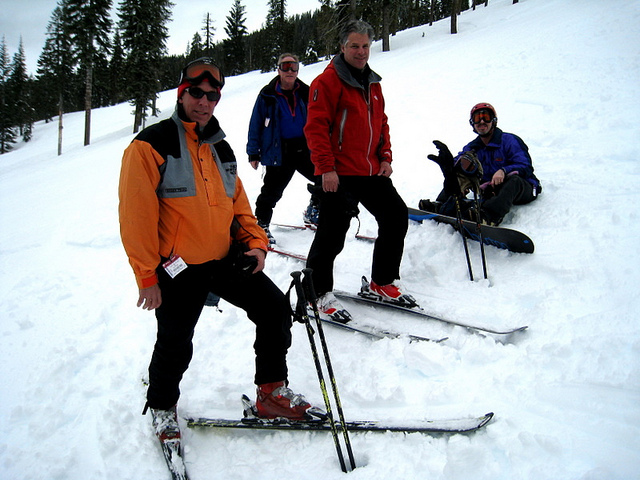

In [ ]:
from PIL import Image
from IPython.display import display
image = Image.open('/content/train2014/COCO_train2014_000000432526.jpg')
display(image)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Load embeddings from .npz file
npz_file = '/content/drive/MyDrive/processed_llava_instruct_data.npz'
data = np.load(npz_file)

# Load the embeddings from the file (modify key names as needed)
clip_embeddings = data['image_embeddings']  # Use appropriate key (e.g., 'image_embeddings', 'prompt_embeddings')
clip_embeddings = torch.tensor(clip_embeddings)  # Convert to torch tensor for further processing

In [ ]:
# Define a Projection Layer
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionLayer, self).__init__()
        # A simple linear layer to project from input_dim to output_dim
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Initialize Projection Layer
input_dim = clip_embeddings.shape[1]  # Input dimension is the size of the CLIP embeddings
output_dim = 256  # Example output dimension, can be modified to fit Phi model requirements
projection_layer = ProjectionLayer(input_dim, output_dim)

# Transfer the projection layer to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
projection_layer = projection_layer.to(device)

# Move embeddings to the same device
clip_embeddings = clip_embeddings.to(device)

# Pass the embeddings through the projection layer
with torch.no_grad():
    projected_embeddings = projection_layer(clip_embeddings)

# Check the shape of the projected embeddings
print(f"Shape of projected embeddings: {projected_embeddings.shape}")



Shape of projected embeddings: torch.Size([303539, 256])


In [ ]:
# pip install -U transformers

In [ ]:
!pip install peft

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_model, LoraConfig, TaskType

In [ ]:
class Instruct150kDataset(Dataset):
    def __init__(self, npz_file_path, tokenizer_name="microsoft/phi-2", max_length=512):
        data = np.load(npz_file_path)

        self.ids = data['ids']
        self.prompts = data['prompts']
        self.image_filenames = data['image_filenames']
        self.prompt_embeddings = data['prompt_embeddings']
        self.image_embeddings = data['image_embeddings']

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        image_filename = self.image_filenames[idx]

        # Create a structured prompt
        structured_prompt = f"Image: {image_filename}\nPrompt: {prompt}\nResponse:"

        # Tokenize the structured prompt
        encoded_prompt = self.tokenizer(structured_prompt, padding='max_length', truncation=True,
                                        max_length=self.max_length, return_tensors='pt')

        return {
            'id': self.ids[idx],
            'input_ids': encoded_prompt['input_ids'].squeeze(),
            'attention_mask': encoded_prompt['attention_mask'].squeeze(),
            'prompt_embedding': torch.tensor(self.prompt_embeddings[idx], dtype=torch.float),
            'image_embedding': torch.tensor(self.image_embeddings[idx], dtype=torch.float)
        }

def load_and_prepare_data(npz_file_path, batch_size=16, tokenizer_name="microsoft/phi-2", max_length=512):
    dataset = Instruct150kDataset(npz_file_path, tokenizer_name, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

class Phi2WithProjection(torch.nn.Module):
    def __init__(self, base_model, embedding_dim=512):
        super().__init__()
        self.base_model = base_model
        self.prompt_projection = torch.nn.Linear(embedding_dim, self.base_model.config.hidden_size)
        self.image_projection = torch.nn.Linear(embedding_dim, self.base_model.config.hidden_size)

    def forward(self, input_ids, attention_mask, prompt_embedding, image_embedding):
        # Project embeddings
        projected_prompt = self.prompt_projection(prompt_embedding)
        projected_image = self.image_projection(image_embedding)

        # Get the original embeddings from the base model
        original_embeds = self.base_model.get_input_embeddings()(input_ids)

        # Combine the embeddings
        # Here we're simply adding the projected embeddings to the first token embedding
        # You might want to experiment with different ways of incorporating these embeddings
        combined_embeds = original_embeds.clone()
        combined_embeds[:, 0, :] += projected_prompt + projected_image

        # Pass through the model
        outputs = self.base_model(inputs_embeds=combined_embeds, attention_mask=attention_mask)
        return outputs

# Training loop
def train(model, dataloader, num_epochs, learning_rate):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            prompt_embedding = batch['prompt_embedding'].to(device)
            image_embedding = batch['image_embedding'].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            prompt_embedding=prompt_embedding,
                            image_embedding=image_embedding)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")



In [ ]:
# Main execution
if __name__ == "__main__":
    npz_file_path = '/content/drive/MyDrive/processed_llava_instruct_data.npz'
    dataloader = load_and_prepare_data(npz_file_path)

    base_model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2")
    model = Phi2WithProjection(base_model)

    # Apply LoRA
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["query_key_value"],
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )
    model = get_peft_model(model, lora_config)

    train(model, dataloader, num_epochs=3, learning_rate=5e-5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import json

# Load the text embeddings
npz_file = '/content/drive/MyDrive/processed_llava_instruct_data.npz'
text_data = np.load(npz_file)

# Load the original dataset to check the instructions
json_file = '/content/llava_instruct_150k.json'
with open(json_file, 'r') as f:
    dataset = json.load(f)

# Check the keys in the text embeddings
print(f"Keys in text embeddings: {text_data.keys()}")

# Verify the shape of the text embeddings
print(f"Shape of text embeddings: {text_data['text_embeddings'].shape}")

# Print a few samples of the text embeddings and their corresponding instructions
for i in range(min(5, len(dataset))):  # Print up to 5 samples
    instruction = dataset[i]['instruction']
    text_embedding = text_data['text_embeddings'][i]  # Assuming the order matches
    print(f"Instruction {i}: {instruction}")
    print(f"Text Embedding {i}: {text_embedding}\n")

Keys in text embeddings: KeysView(NpzFile '/content/drive/MyDrive/processed_llava_instruct_data.npz' with keys: ids, prompts, image_filenames, prompt_embeddings, image_embeddings)


KeyError: 'text_embeddings is not a file in the archive'

In [ ]:
text_data = np.load(npz_file)
text_data["prompts"]


array(['<image>\nWhat are the colors of the bus in the image?',
       'What feature can be seen on the back of the bus?',
       'Is the bus driving down the street or pulled off to the side?',
       ...,
       '<image>\nWhat considerations must the train conductor and passengers take into account while boarding the train in this situation?',
       '<image>\nWhat advice could the man in the image give to someone just starting their career?',
       '<image>\nWhat might be the purpose of the items displayed on the table?'],
      dtype='<U274')

In [ ]:
dataset[100]

{'id': '000000392035',
 'image': '000000392035.jpg',
 'conversations': [{'from': 'human',
   'value': 'What is the man doing in the image?\n<image>'},
  {'from': 'gpt',
   'value': 'The man is sitting in a chair, possibly at his computer, with a bird (a parrot) on his shoulder.'},
  {'from': 'human',
   'value': 'Is there any other animal present in the image?'},
  {'from': 'gpt',
   'value': 'Yes, there is a cat in the image, which the man is petting while sitting at his computer.'},
  {'from': 'human', 'value': "What type of bird is on the man's shoulder?"},
  {'from': 'gpt', 'value': "The bird on the man's shoulder is a parrot."},
  {'from': 'human', 'value': 'Where is the parrot positioned on the man?'},
  {'from': 'gpt',
   'value': "The parrot is positioned on the man's shoulder, keeping its balance as the man sits and interacts with his cat."},
  {'from': 'human',
   'value': 'What might be the significance of the interaction between the man and the animals in the image?'},
  {'

In [ ]:
import pandas as pd
import numpy as np

# Load the LLaVA dataset
df = pd.read_json('llava_instruct_150k.json')

# Load the image embeddings
image_embeddings = text_data['image_embeddings']
image_embeddings
# Extract conversations and create a new DataFrame
conversations = []
for index, row in df.iterrows():
    conversation_list = []
    for conversation in row['conversations']:
        conversation_list.append(f"{conversation['from']}: {conversation['value']}")
    conversations.append({
        'id': row['id'],
        'image': row['image'],
        'conversation': '\n'.join(conversation_list)
    })

df_conversations = pd.DataFrame(conversations)

# Add image embeddings to the DataFrame
df_conversations['image_embedding'] = df_conversations['id'].apply(lambda x: image_embeddings[x] if x < len(image_embeddings) else None)

In [ ]:
df_conversations

,id,image,conversation,image_embedding
0,33471,000000033471.jpg,human: <image>\nWhat are the colors of the bus...,"[0.031173835, 0.0048769685, -0.007295706, 0.03..."
1,52846,000000052846.jpg,human: Where is the cat positioned in the imag...,"[0.005160859, 0.007221058, 0.025367444, 0.0328..."
2,334872,000000334872.jpg,human: <image>\nAre the people in the image sk...,None
3,319154,000000319154.jpg,human: <image>\nWhat color is the dog in the i...,None
4,398214,000000398214.jpg,human: What type of sign and traffic device ca...,None
...,...,...,...,...
157707,257414,000000257414.jpg,human: <image>\nWhat could be the train's purp...,"[0.046541702, -0.0143144, 0.012999924, 0.06892..."
157708,171272,000000171272.jpg,human: What are the advantages and disadvantag...,"[-0.04477071, 0.018555162, -0.010334117, 0.039..."
157709,101038,000000101038.jpg,human: What precautions should be taken to ens...,"[0.0016455172, 0.016408592, -0.013720064, 0.04..."
157710,124934,000000124934.jpg,human: <image>\nWhat risks do skateboarders fa...,"[-0.021641344, 0.017126128, -0.004181812, 0.02..."


In [ ]:
df_conversations['conversation'] = df_conversations['conversation'].str.replace('<image>\n', '', regex=False)

In [ ]:
df_conversations['image_path'] = '/content/train2014/' + 'COCO_train2014_' + df_conversations['image']

In [ ]:
df_conversations

,id,image,conversation,image_embedding,image_path
0,33471,000000033471.jpg,human: What are the colors of the bus in the i...,"[0.031173835, 0.0048769685, -0.007295706, 0.03...",/content/train2014/COCO_train2014_000000033471...
1,52846,000000052846.jpg,human: Where is the cat positioned in the imag...,"[0.005160859, 0.007221058, 0.025367444, 0.0328...",/content/train2014/COCO_train2014_000000052846...
2,334872,000000334872.jpg,human: Are the people in the image skiing down...,None,/content/train2014/COCO_train2014_000000334872...
3,319154,000000319154.jpg,human: What color is the dog in the image?\ngp...,None,/content/train2014/COCO_train2014_000000319154...
4,398214,000000398214.jpg,human: What type of sign and traffic device ca...,None,/content/train2014/COCO_train2014_000000398214...
...,...,...,...,...,...
157707,257414,000000257414.jpg,human: What could be the train's purpose in th...,"[0.046541702, -0.0143144, 0.012999924, 0.06892...",/content/train2014/COCO_train2014_000000257414...
157708,171272,000000171272.jpg,human: What are the advantages and disadvantag...,"[-0.04477071, 0.018555162, -0.010334117, 0.039...",/content/train2014/COCO_train2014_000000171272...
157709,101038,000000101038.jpg,human: What precautions should be taken to ens...,"[0.0016455172, 0.016408592, -0.013720064, 0.04...",/content/train2014/COCO_train2014_000000101038...
157710,124934,000000124934.jpg,human: What risks do skateboarders face while ...,"[-0.021641344, 0.017126128, -0.004181812, 0.02...",/content/train2014/COCO_train2014_000000124934...


In [ ]:
df['image_path'] = '/content/train2014/' + 'COCO_train2014_' + df['image']
df

,id,image,conversations,image_path
0,33471,000000033471.jpg,"[{'from': 'human', 'value': '<image> What are ...",/content/train2014/COCO_train2014_000000033471...
1,52846,000000052846.jpg,"[{'from': 'human', 'value': 'Where is the cat ...",/content/train2014/COCO_train2014_000000052846...
2,334872,000000334872.jpg,"[{'from': 'human', 'value': '<image> Are the p...",/content/train2014/COCO_train2014_000000334872...
3,319154,000000319154.jpg,"[{'from': 'human', 'value': '<image> What colo...",/content/train2014/COCO_train2014_000000319154...
4,398214,000000398214.jpg,"[{'from': 'human', 'value': 'What type of sign...",/content/train2014/COCO_train2014_000000398214...
...,...,...,...,...
157707,257414,000000257414.jpg,"[{'from': 'human', 'value': '<image> What coul...",/content/train2014/COCO_train2014_000000257414...
157708,171272,000000171272.jpg,"[{'from': 'human', 'value': 'What are the adva...",/content/train2014/COCO_train2014_000000171272...
157709,101038,000000101038.jpg,"[{'from': 'human', 'value': 'What precautions ...",/content/train2014/COCO_train2014_000000101038...
157710,124934,000000124934.jpg,"[{'from': 'human', 'value': '<image> What risk...",/content/train2014/COCO_train2014_000000124934...


In [ ]:
def flatten_conversation(conversation):
  human_value = next((d['value'] for d in conversation if d['from'] == 'human'), None)
  gpt_value = next((d['value'] for d in conversation if d['from'] == 'gpt'), None)
  return human_value, gpt_value

df[['human_value', 'gpt_value']] = df['conversations'].apply(flatten_conversation).apply(pd.Series)



            id             image  \
0        33471  000000033471.jpg   
1        52846  000000052846.jpg   
2       334872  000000334872.jpg   
3       319154  000000319154.jpg   
4       398214  000000398214.jpg   
...        ...               ...   
157707  257414  000000257414.jpg   
157708  171272  000000171272.jpg   
157709  101038  000000101038.jpg   
157710  124934  000000124934.jpg   
157711  163917  000000163917.jpg   

                                            conversations  \
0       [{'from': 'human', 'value': '<image>
What are ...   
1       [{'from': 'human', 'value': 'Where is the cat ...   
2       [{'from': 'human', 'value': '<image>
Are the p...   
3       [{'from': 'human', 'value': '<image>
What colo...   
4       [{'from': 'human', 'value': 'What type of sign...   
...                                                   ...   
157707  [{'from': 'human', 'value': '<image>
What coul...   
157708  [{'from': 'human', 'value': 'What are the adva...   
157709  [{'from': 

In [ ]:
df

,id,image,conversations,image_path,human_value,gpt_value
0,33471,000000033471.jpg,"[{'from': 'human', 'value': '<image> What are ...",/content/train2014/COCO_train2014_000000033471...,<image>\nWhat are the colors of the bus in the...,The bus in the image is white and red.
1,52846,000000052846.jpg,"[{'from': 'human', 'value': 'Where is the cat ...",/content/train2014/COCO_train2014_000000052846...,Where is the cat positioned in the image?\n<im...,The cat is positioned on top of the back of th...
2,334872,000000334872.jpg,"[{'from': 'human', 'value': '<image> Are the p...",/content/train2014/COCO_train2014_000000334872...,<image>\nAre the people in the image skiing do...,The people in the image are cross-country skii...
3,319154,000000319154.jpg,"[{'from': 'human', 'value': '<image> What colo...",/content/train2014/COCO_train2014_000000319154...,<image>\nWhat color is the dog in the image?,The dog in the image is brown.
4,398214,000000398214.jpg,"[{'from': 'human', 'value': 'What type of sign...",/content/train2014/COCO_train2014_000000398214...,What type of sign and traffic device can be se...,"In the image, there is a street sign and a tra..."
...,...,...,...,...,...,...
157707,257414,000000257414.jpg,"[{'from': 'human', 'value': '<image> What coul...",/content/train2014/COCO_train2014_000000257414...,<image>\nWhat could be the train's purpose in ...,Based on the image of a long white and red tra...
157708,171272,000000171272.jpg,"[{'from': 'human', 'value': 'What are the adva...",/content/train2014/COCO_train2014_000000171272...,What are the advantages and disadvantages of u...,Advantages of using a motorcycle with a sideca...
157709,101038,000000101038.jpg,"[{'from': 'human', 'value': 'What precautions ...",/content/train2014/COCO_train2014_000000101038...,What precautions should be taken to ensure the...,To ensure the safety and productivity of the h...
157710,124934,000000124934.jpg,"[{'from': 'human', 'value': '<image> What risk...",/content/train2014/COCO_train2014_000000124934...,<image>\nWhat risks do skateboarders face whil...,Skateboarders face several risks while perform...


,157711
id,163917
image,000000163917.jpg
conversation,human: How could someone make a similar arrang...
image_embedding,"[-0.036989473, 0.011842297, -0.007111309, 0.00..."
image_path,/content/train2014/COCO_train2014_000000163917...


In [ ]:
import json
# Opening JSON file - instruct150k
f = open('llava_instruct_150k.json')

# returns JSON object as
# a dictionary
data = json.load(f)
data[0]

{'id': '000000033471',
 'image': '000000033471.jpg',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat are the colors of the bus in the image?'},
  {'from': 'gpt', 'value': 'The bus in the image is white and red.'},
  {'from': 'human',
   'value': 'What feature can be seen on the back of the bus?'},
  {'from': 'gpt', 'value': 'The back of the bus features an advertisement.'},
  {'from': 'human',
   'value': 'Is the bus driving down the street or pulled off to the side?'},
  {'from': 'gpt',
   'value': 'The bus is driving down the street, which is crowded with people and other vehicles.'}]}

In [ ]:
# Data Preparation
data_instruct150_flatten = []  # Initialize an empty list to store flattened data
r = 0  # Counter for printing progress

# Iterate over each item in the 'data' list
for a_idx, d in enumerate(data):
    # Extract image information
    image = d['image']
    image_url = 'http://images.cocodataset.org/train2017/' + image

    # Iterate over conversations
    conv_iter = iter(d['conversations'])
    for i in conv_iter:
        # Get next conversation item (assumed to be GPT response)
        gpt_ans = next(conv_iter)

        # Filter out long answers
        if len(gpt_ans['value']) > 200:
            continue

        # Add to flattened list if it's a human-to-GPT conversation
        if i['from'] == 'human' and gpt_ans['from'] == 'gpt':
            # Append image URL, human message, and GPT response
            data_instruct150_flatten.append((image_url, i['value'].replace('<image>\n', '').replace('\n<image>', ''), gpt_ans['value']))

    # Print progress every 10,000 items
    if a_idx % 10000 == 0:
        print(f"{10000 * r} processed")
        r += 1

0 processed
10000 processed
20000 processed
30000 processed
40000 processed
50000 processed
60000 processed
70000 processed
80000 processed
90000 processed
100000 processed
110000 processed
120000 processed
130000 processed
140000 processed
150000 processed


In [ ]:

data_instruct150_flatten[4]

('http://images.cocodataset.org/train2017/000000052846.jpg',
 'What is the cat doing in the image?',
 'The cat is coming out from some curtains onto the couch and is sitting or standing on top of it.')

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
from transformers import AutoTokenizer

In [ ]:
# add tokens
phi_model_name  = "microsoft/phi-2"
tokenizer  = AutoTokenizer.from_pretrained(phi_model_name, trust_remote_code=True)
tokenizer.add_tokens('[QA]')
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
tokenizer.pad_token, tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

('[PAD]', '<|endoftext|>')

In [ ]:
import csv
# gpt like training dataset
with open('train_token.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([['img_url','input','label']])

train_data_temp = []
r = 1
for df in data_instruct150_flatten:
  image_url = df[0]
  image_q   = df[1] + ' [QA]'
  image_a   = df[2] +  tokenizer.eos_token
  #print(image_q)
  #print(image_a)

  # tokenise
  ques_token = tokenizer(image_q, return_tensors="pt", return_attention_mask=False)['input_ids'].squeeze(0)
  ans_token  = tokenizer(image_a, return_tensors="pt", return_attention_mask=False)['input_ids'].squeeze(0)

  #print(ques_token)
  #print(ans_token)
  #break

  context_length = len(ques_token)
  combo_q_a = torch.cat( [ques_token,ans_token])

  for al in range(len(ans_token)):
    input = combo_q_a[al : al + context_length].numpy()
    label = combo_q_a[al + 1 : al + context_length + 1].numpy()
    train_data_temp.append([image_url,input,label])
    if len(train_data_temp) >= 100000: # write to the file
       print(f"Writing to disk after {r * 100000} rows")
       r += 1
       with open('train_token.csv', 'a', newline='') as file:
          writer = csv.writer(file)
          writer.writerows(train_data_temp)
       train_data_temp = []

Writing to disk after 100000 rows
Writing to disk after 200000 rows
Writing to disk after 300000 rows
Writing to disk after 400000 rows
Writing to disk after 500000 rows
Writing to disk after 600000 rows
Writing to disk after 700000 rows
Writing to disk after 800000 rows
Writing to disk after 900000 rows
Writing to disk after 1000000 rows
Writing to disk after 1100000 rows
Writing to disk after 1200000 rows
Writing to disk after 1300000 rows
Writing to disk after 1400000 rows
Writing to disk after 1500000 rows
Writing to disk after 1600000 rows
Writing to disk after 1700000 rows
Writing to disk after 1800000 rows
Writing to disk after 1900000 rows
Writing to disk after 2000000 rows
Writing to disk after 2100000 rows
Writing to disk after 2200000 rows
Writing to disk after 2300000 rows
Writing to disk after 2400000 rows
Writing to disk after 2500000 rows
Writing to disk after 2600000 rows
Writing to disk after 2700000 rows
Writing to disk after 2800000 rows
Writing to disk after 2900000